# Target Encoding

TODO: intro about ways to encode categorical cols: label, one-hot, and entity embbeddings (if you were using a neural net or gradient descent-based method, but can't do that if you want to use say xgboost).  Problem w/ label encoding is doesn't work at all w/ non-ordinal features w/ a high # of categories (or at all at all w/ a linear model).  Problem w/ one-hot is that it can create a crazy number of columns.  

TODO: One solution is to use target encoding, where you replace each category with the mean target value for samples having that category.  However, blindly using target encoding can allow data leakage, leading to overfitting and poor predictive performance!  To fix that problem, have to do cross-fold target encoding.

TODO: but even with cross-fold target encoding, there are situations where you'd be better off with one-hot or other encoding methods: one-hot is usually better in situations with few categories, balanced categories, and one-hot is definitely better when there are important interaction effects.

In this post we'll evaluate different encoding schemes, build a cross-fold target encoder to mitigate the drawbacks of the naive target encoder, and determine how the performance of predictive models change based on the type of category encoding used, the number of categories in the dataset, and the presence of interaction effects. 

TODO: outline

First let's import the packages we'll be using.

In [0]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

np.random.seed(12345)

Regressor = BayesianRidge()
#Regressor = Lasso(alpha=0.5)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Data

To evaluate the effectiveness of different encoding algorithms, we'll want to be able to generate data with different numbers of samples, features, and categories.  Let's make a function to generate categorical datasets, which allows us to set these different aspects of the data.

TODO: think there's a bug somewhere in the data-generating func - w/ noise=1, even w/ perfect inference should only be able to get down to MAE of ~0.8, and OHE gets down to like 0.23...  And then cross-fold TE is worse than chance...

In [0]:
def make_categorical_regression(n_samples=100,
                                n_features=10,
                                n_informative=10,
                                n_categories=10,
                                imbalance=0.0,
                                noise=1.0,
                                n_cont_features=10,
                                cont_weight=0.1):
    """Generate a regression problem with only categorical features.
  
    Parameters
    ----------
    n_samples : int > 0
        Number of samples to generate
    n_features : int > 0
        Number of categorical features to generate
    n_informative : int >= 0
        Number of features which carry information about the target
    n_categories : int > 0
        Number of categories per feature.
    imbalance : float > 0
        How much imbalance there is in the number of occurrences of
        each category.  Larger values yield a higher concentration
        of samples in only a few categories.  An imbalance of 0 
        yields the same number of samples in each category.
    noise : float > 0
        Noise to add to target
    n_cont_features : int >= 0
        Number of continuous (non-categorical) features.
    cont_weight : float > 0
        Weight of the continuous variables' effect.
        
    Returns
    -------
    X : pandas DataFrame of shape (n_samples, n_features)
        Categorical features.
    y : pandas Series of shape (n_samples,)
        Target variable.
    """
    
    
    def beta_binomial(n, a, b):
        """Beta-binomial probability mass function.
        
        Parameters
        ----------
        n : int
            Number of trials
        a : float > 0
            Alpha parameter
        b : float > 0
            Beta parameter
            
        Returns
        -------
        ndarray of size (n,)
            Probability mass function.
        """
        from scipy.special import beta
        from scipy.misc import comb
        k = np.arange(n+1)
        return comb(n, k)*beta(k+a, n-k+b)/beta(a, b)


    # Check inputs
    if not isinstance(n_samples, int):
        raise TypeError('n_samples must be an int')
    if n_samples < 1:
        raise ValueError('n_samples must be one or greater')
    if not isinstance(n_features, int):
        raise TypeError('n_features must be an int')
    if n_features < 1:
        raise ValueError('n_features must be one or greater')
    if not isinstance(n_informative, int):
        raise TypeError('n_informative must be an int')
    if n_informative < 0:
        raise ValueError('n_informative must be non-negative')
    if not isinstance(n_categories, int):
        raise TypeError('n_categories must be an int')
    if n_categories < 1:
        raise ValueError('n_categories must be one or greater')
    if not isinstance(imbalance, float):
        raise TypeError('imbalance must be a float')
    if imbalance < 0:
        raise ValueError('imbalance must be non-negative')
    if not isinstance(noise, float):
        raise TypeError('noise must be a float')
    if noise < 0:
        raise ValueError('noise must be positive')
    if not isinstance(n_cont_features, int):
        raise TypeError('n_cont_features must be an int')
    if n_cont_features < 0:
        raise ValueError('n_cont_features must be non-negative')
    if not isinstance(cont_weight, float):
        raise TypeError('cont_weight must be a float')
    if cont_weight < 0:
        raise ValueError('cont_weight must be non-negative')
        
        
    # Generate random categorical data (using category probabilities
    # drawn from a beta-binomial dist w/ alpha=1, beta=imbalance+1)
    cat_probs = beta_binomial(n_categories-1, 1.0, imbalance+1)
    categories = np.empty((n_samples, n_features), dtype='uint64')
    for iC in range(n_features):
        categories[:,iC] = np.random.choice(np.arange(n_categories),
                                            size=n_samples,
                                            p=cat_probs)
        
    # Generate random values for each category
    cat_vals = np.random.randn(n_categories, n_features)
    
    # Set non-informative columns' effect to 0
    cat_vals[:,:(n_features-n_informative)] = 0
    
    # Compute target variable from those categories and their values
    y = np.zeros(n_samples)
    for iC in range(n_features):
      y += cat_vals[categories[:,iC], iC]
    
    # Add noise
    y += noise*np.random.randn(n_samples)
    
    # Generate dataframe from categories
    cat_strs = [''.join([chr(ord(c)+49) for c in str(n)]) 
                for n in range(n_categories)]
    X = pd.DataFrame()
    for iC in range(n_features):
        col_str = 'categorical_'+str(iC)
        X[col_str] = [cat_strs[i] for i in categories[:,iC]]
        
    # Add continuous features
    for iC in range(n_cont_features):
        col_str = 'continuous_'+str(iC)
        X[col_str] = cont_weight*np.random.randn(n_samples)
        y += np.random.randn()*X[col_str]
                    
    # Generate series from target
    y = pd.Series(data=y, index=X.index)
    
    # Return features and target
    return X, y

Now, we can easily generate data to test our encoders on:

In [59]:
# Generate categorical data and target
X, y = make_categorical_regression(n_samples=2000,
                                   n_features=10,
                                   n_categories=100,
                                   n_informative=1,
                                   imbalance=2.0,
                                   n_cont_features=0)

# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


The features are all categorical (stored as "objects"):

In [60]:
X_train.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
792,cf,c,d,a,ed,ca,dj,g,b,bj
276,di,b,bd,fg,d,j,e,a,hc,h
1016,ei,di,cj,he,hb,gh,b,bh,df,c
1372,ca,c,be,ce,cg,bf,de,fe,ba,fd
1860,db,dh,ba,bh,di,bh,db,bi,gf,bi
1431,h,ce,ea,i,eb,g,da,da,fc,e
328,j,db,df,fa,fe,g,c,h,da,bg
1708,cd,ci,f,be,e,fb,dc,bi,ec,da
1567,ei,cj,ch,bc,bb,f,ch,bi,c,he
1027,bi,bh,bf,ba,dc,da,g,cc,bi,ee


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 523 to 583
Data columns (total 10 columns):
categorical_0    1000 non-null object
categorical_1    1000 non-null object
categorical_2    1000 non-null object
categorical_3    1000 non-null object
categorical_4    1000 non-null object
categorical_5    1000 non-null object
categorical_6    1000 non-null object
categorical_7    1000 non-null object
categorical_8    1000 non-null object
categorical_9    1000 non-null object
dtypes: object(10)
memory usage: 85.9+ KB


But the target variable is continuous:

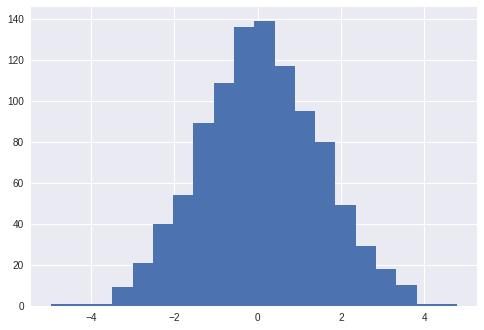

In [62]:
y_train.hist(bins=20)

Let's see which category encoding scheme best allows us to predict the target variable!

## Baseline

For comparison, how well would we do if we just predicted the mean?  We'll use the mean absolute error as our performance metric.

In [63]:
mean_absolute_error(y_train, 
                    np.full(y_train.shape[0], y_train.mean()))

1.139564825988808

So, we should definitely be shooting for a mean absolute error of less than that!  But, we added random noise with a standard deviation of 1, so the best MAE we can expect is:

In [64]:
mean_absolute_error(np.random.randn(10000), np.zeros(10000))

0.7995403442995148

## Label Encoding

TODO: prediction w/ simple label encoding, which is just replacing each unique category w/ a unique integer

TODO: note that we could also use Scikit-learn's LabelEncoder

In [0]:
class LabelEncoder(BaseEstimator, TransformerMixin):
    """Label encoder.
    
    Replaces categorical column(s) with integer labels for each unique
    category in original column.

    """
    
    def __init__(self, cols=None):
        """Label encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to label encode.  Default is to label encode 
            all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit label encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Create the map from objects to integers for each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = dict(zip(
                X[col].values, 
                X[col].astype('category').cat.codes.values
            ))
                        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the label encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
          
            # Map the column
            Xo[col] = Xo[col].map(tmap)
            
            # Convert to appropriate datatype
            max_val = max(tmap.values())
            if Xo[col].isnull().any(): #nulls, so have to use float!
                if max_val < 8388608:
                    dtype = 'float32'
                else:
                    dtype = 'float64'
            else:
                if max_val < 256:
                    dtype = 'uint8'
                elif max_val < 65536:
                    dtype = 'uint16'
                elif max_val < 4294967296:
                    dtype = 'uint32'
                else:
                    dtype = 'uint64'
            Xo[col] = Xo[col].astype(dtype)
            
        # Return encoded dataframe
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

Now we can convert the categories to integers:

In [66]:
# Label encode the categorical data
le = LabelEncoder()
X_label_encoded = le.fit_transform(X_train, y_train)
X_label_encoded.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
884,13,40,83,5,82,32,44,6,23,55
1098,15,66,34,70,56,36,69,3,86,48
853,56,6,12,30,27,25,56,10,54,6
1667,17,6,77,8,22,65,22,33,5,22
1136,56,5,8,34,0,31,48,80,50,56
362,0,15,47,50,42,7,9,3,81,34
1977,21,19,22,56,56,13,1,43,13,34
1784,35,66,37,66,4,1,76,8,1,10
127,82,42,11,63,12,39,58,76,59,67
1489,2,66,35,1,4,1,45,24,23,24


But again, these integers aren't related to the categories in any meaningful way - aside from the fact that each unique integer corresponds to a unique category.

TODO: then we can make a model to predict

In [67]:
# Regression model
model_le = Pipeline([
    ('label-encoder', LabelEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Regressor)
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 1.13197409773137 +/- 0.021768461339780148


TODO: That's not much better than just predicting the mean!

However, the error is no worse on the test data than the cross-validated error on the training data.



In [68]:
# MAE on test data
model_le.fit(X_train, y_train)
y_pred = model_le.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 1.175866100844089


## One-hot Encoding

TODO: one-hot encoding, sometimes aka "Dummy encoding"

(note that we could also use Scikit-learn's OneHotEncoder)

In [0]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    """One-hot encoder.
    
    Replaces categorical column(s) with binary columns for each unique
    value in original column.

    """
    
    def __init__(self, cols=None, reduce_df=False):
        """One-hot encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to one-hot encode.  Default is to one-hot encode 
            all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to add N-1 one-hot columns for a column with N 
            categories. E.g. for a column with categories A, B, and C:
            When reduce_df is True, A=[1, 0], B=[0, 1], and C=[0, 0]
            When reduce_df is False, A=[1, 0, 0], B=[0, 1, 0], and 
            C=[0, 0, 1]
            Default = False
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        self.reduce_df = reduce_df
        
        
    def fit(self, X, y):
        """Fit one-hot encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Store each unique value
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.maps[col].append(unique)
            if self.reduce_df:
                del self.maps[col][-1]
        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the one-hot encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, vals in self.maps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via one-hot encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

Now, instead of replacing categories with integer labels, we've create a new column for each category in each original column.  The value in a given column is 1 when the original category matches, otherwise the value is 0.

In [70]:
# One-hot-encode the categorical data
ohe = OneHotEncoder()
X_one_hot = ohe.fit_transform(X_train, y_train)
X_one_hot.sample(10)

,categorical_0_ec,categorical_0_ba,categorical_0_bg,categorical_0_b,categorical_0_h,categorical_0_j,categorical_0_ge,categorical_0_cg,categorical_0_fh,categorical_0_dc,...,categorical_9_ga,categorical_9_eb,categorical_9_gg,categorical_9_hj,categorical_9_gi,categorical_9_he,categorical_9_ff,categorical_9_hb,categorical_9_gd,categorical_9_fi
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can fit the same model with the one-hot encoded data as we fit to the label-encoded data.

In [71]:
# Regression model
model_oh = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Regressor)
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 1.0386222429286203 +/- 0.028114652268138147


TODO: better than just guessing the mean, but not by a whole lot!

In [72]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 1.028751865940599


## Target Encoding

TODO: target encoding replaces categorical vals w/ the mean of the target for that category

In [0]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target encode all 
            categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

TODO: now we can replace each categorical value with a continuous vaule corresponding to the mean of the target value for that category.

In [74]:
# Target encode the categorical data
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)
X_target_encoded.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
711,-0.030636,0.192812,0.269273,0.131628,0.319769,0.190861,0.142159,0.393587,-0.766454,-0.312227
475,0.365423,-0.605778,-0.258930,0.038321,-0.283131,0.046135,0.316052,-0.120822,-0.425927,-0.163454
273,0.110462,1.093313,0.309760,0.474308,0.090909,0.003120,1.558923,0.244971,-0.387846,-0.327537
9,-0.848020,0.300673,0.125095,-0.650361,-0.252932,0.293856,-0.197504,0.050085,-0.587633,-0.413439
275,0.126068,0.180776,-0.143977,-0.131238,0.090909,-0.760367,0.326620,-0.037488,-0.121713,-0.244310
336,0.543412,-0.045947,0.180144,0.279675,-0.532591,0.338287,0.071977,0.113531,0.527567,1.290724
1462,-0.065061,-0.605778,0.172445,-0.268622,-0.283131,-0.270112,-0.197504,0.068821,0.371461,0.966579
1436,0.186988,0.564015,0.135396,0.474308,0.338006,0.479294,0.063384,0.342170,-0.054090,-0.163454
1611,0.350326,-0.188197,-0.537682,-0.391143,0.212399,-1.811086,0.204642,-0.622682,-0.425927,-0.489371
166,0.480637,0.975462,0.135396,-0.131238,0.323870,0.279502,-0.533179,0.050085,0.016449,1.410449


TODO: note that each column has exactly as many unique continuous values as it did categories.  This is because we've simply replaced the category with the mean target value for that category.

In [75]:
X_target_encoded.nunique()

categorical_0    84
categorical_1    81
categorical_2    85
categorical_3    88
categorical_4    84
categorical_5    86
categorical_6    88
categorical_7    88
categorical_8    90
categorical_9    79
dtype: int64

TODO: then we can fit the same model as before...

In [76]:
# Regression model
model_te = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Regressor)
])

# Cross-validated MAE
scores = cross_val_score(model_te, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.9402165006761526 +/- 0.029713106940791913


TODO: performance on the test data is about the same, but slightly better (because we've given it more samples to test on)


In [77]:
# MAE on test data
model_te.fit(X_train, y_train)
y_pred = model_te.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 0.9325682408250325


TODO: uhhhh?

## Cross-Fold Target Encoding

TODO: problems w/ just target encoding (your performance on the test data goes way down relative to your CV score), and why it happens (b/c you're causing data leakage by allowing i-th sample's y variable to effect the value of the i-th sample's X variable which you're encoding) 

TODO: this can be fixed w/ cross-fold target encoding

In [0]:
class TargetEncoderCV(TargetEncoder):
    """Cross-validated target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-validated target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-validation splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-validated target encoding for the training fold, and uses
        normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:], y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

With this encoder, we can convert the categories into continuous values, just like we did with the naive target encoding.

In [79]:
# Cross-fold Target encode the categorical data
te = TargetEncoderCV()
X_target_encoded_cv = te.fit_transform(X_train, y_train)
X_target_encoded_cv.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
236,0.233017,0.266851,0.620411,-0.0917691,0.0238002,0.205387,-0.182844,0.209843,-0.201101,1.95302
103,0.0419825,-0.133423,-0.152355,0.768532,-0.105238,-0.0010254,-0.0768051,-0.164632,-0.108223,-1.16817
502,0.335987,0.686906,0.00831367,0.780618,0.253249,-0.588782,-0.0104415,-0.139042,0.258339,2.08561
870,0.251286,-0.221214,-0.21522,-0.528595,-0.320334,0.484078,0.593479,0.131563,0.152882,-0.333682
357,-0.105762,-0.108175,-0.2422,-1.08681,-0.0790136,-0.367782,0.287205,0.542695,0.064133,-0.670692
1372,0.169969,0.366924,0.399639,-0.0954622,0.0220233,-0.588782,-0.529951,0.233605,-0.260713,-0.130225
620,0.372039,0.110516,-0.259249,-0.0814691,0.294292,0.705151,0.300228,0.227451,0.185972,1.53523
1147,-0.294882,0.477974,0.531971,0.210054,-0.171589,-0.106227,0.0837924,-0.201896,-0.595051,0.659421
1650,-0.882803,0.647945,0.177125,-0.190479,0.644579,0.208487,0.657135,0.227451,-0.701029,-0.00746989
68,NaN,0.831874,-0.113836,-0.190479,-0.475449,-1.90497,-0.991536,0.649424,-0.326514,-0.2205


However, now we have more unique continuous values in each column than we did categories, because we've target-encoded the categories separately for each fold.

In [80]:
X_target_encoded_cv.nunique()

categorical_0    214
categorical_1    203
categorical_2    201
categorical_3    203
categorical_4    208
categorical_5    207
categorical_6    207
categorical_7    205
categorical_8    213
categorical_9    200
dtype: int64

TODO: then we can fit the same model as before, but w/ cross-fold target encoding...

In [81]:
# Regression model
model_tecv = Pipeline([
    ('encoder', TargetEncoderCV()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', Regressor)
])

# Cross-validated MAE
scores = cross_val_score(model_tecv, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.8351049783190474 +/- 0.04365424683197591


TODO: and now the validation performance is consistent with the cross-validated performance

In [82]:
# MAE on test data
model_tecv.fit(X_train, y_train)
y_pred = model_tecv.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 0.8389909316238072


## Dependence on Number of Categories

TODO: not using cross-fold TE is worse when there are more categories.

TODO: but if you have a very small number of categories, you may be better off using one-hot (compare mae's as a fn of #categories/#samples)

## Effect of Interactions

TODO: target encoding doesn't capture interactions very well, which one-hot does (in theory?  simulate data w/ important interaction effects and see if it does better than target encoder)

In [0]:
# TODO: add some sort of interactions param to make_categorical_regression func?